# **Introduction**
## Mission

Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    - train
    - test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
  
--- 
---

The goal of this projet is to detect fraudulous signal using Machine Learning and Deep Learning methods.

**Methodology used**:

*Part 1* :
- We explore the data in order to understand is better and select potential features for algorithms.
- We then implement machine learning algorithm in order to establish a first baseline for our goal:
  - Use of XGBoost 
  - Use of Random Forest
- We then compare this baseline using traditional ML algorithm to deep learning methods using neural networks. We process using several paths:
  - We use the same features as in ML algorithms, and implemented neural networks fully connected

*Part 2* 
- We use ResNet architecture

*Part 3*
- We use RNN architecture on raw data

**Dataset used**:
- We use a dataset of 2000 training signal and 800 test signal. 


**Validation metric**:  
- We will use metrics accuracy and recall.

**Results**
- Several models with features or raw data. 
- Due to the relatively few data that we had, deep learning does not necessarilly works better. Standard ML algorithms ended up having the best results. 
- Regarding specific choices made on how to deal with the data in DL algorithms:
  - Padding is useless because the size are too different between all the signals, resulting in random results. 
  - For fully connected architecture, the number of parameters is higher than in RNN for instance (with same number of layers, same hidden size...). Hence, fully connected requires more memory, it would result in a much longer training if we had had more data. 
- Summary of the results for our problem :

| Model type| Type of data | Model | Test accuracy | Test recall | Number of parameters |
|-----------|--------------|-------|---------------|-------------|----------------------|
| Machine learning | Custom features | XG Boost | 87,6% |  85% |  |
| Machine learning | Custom features | Random Forest | 88,5% | 93% |  |
| Machine learning | Custom features | Decision Tree | 84,5% | 84% |  |
| Deep learning | Custom features | Multi Layer Perceptron sklearn | 87,5% | 86% | 592 |
| Deep learning | Custom features | Multi Layer Perceptron PyTorch manually | 81,7% | 78.7% | 801 |
| Deep learning | Custom features | ResNet | 83% | 70% | 125k |
| Deep learning | Raw data | ResNet with padding | 65,5% | 58% | 447k |
| Deep learning | Raw data | ResNet with pooling | 78% | 72% | 159k |
| Deep learning | Raw data | ResNet with pooling with selected features | 80% | 81% | 152k |
| Deep learning | Raw data | RNN with fixed batch sequence length | 75,75% |  73% | 63k |
| Deep learning | Raw data | RNN with adaptative batch sequence length | 76% | 71% | 63k |



In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
pdws = np.load('./train/pdw-0.npz')
dates = pdws['date']
largeurs = pdws['largeur']
frequences = pdws['frequence']
puissances = pdws['puissance']
theta = pdws['theta']
phi = pdws['phi']

features = ["date", "largeur", "frequence", "puissance", "theta", "phi"]

et les fichiers d'annotations:

Le signal pdw-0.npz est de type: nonmenace
(672,)


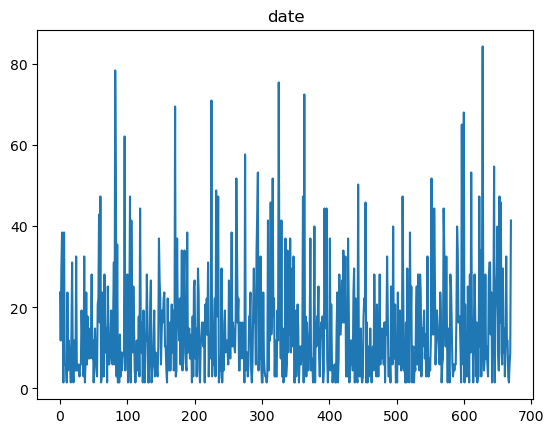

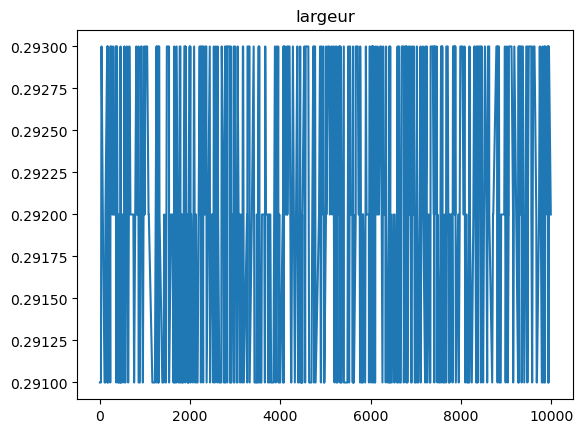

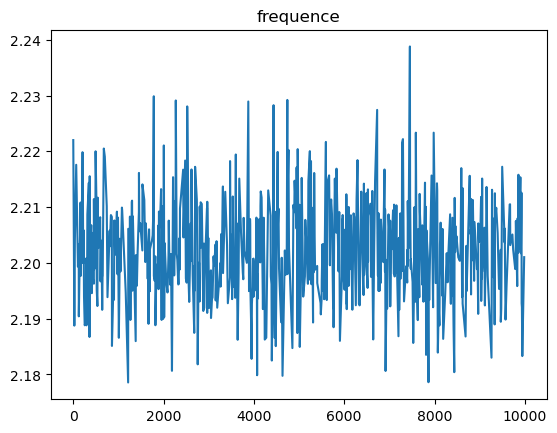

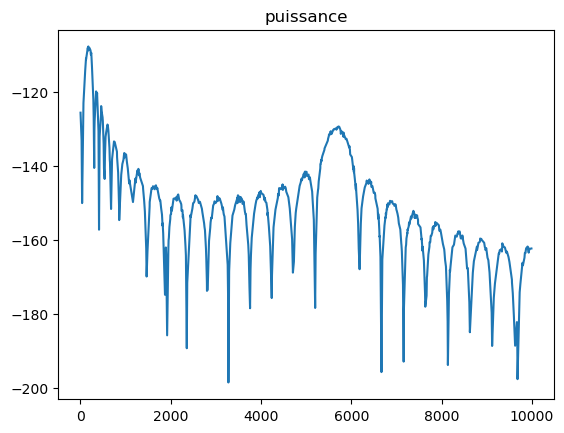

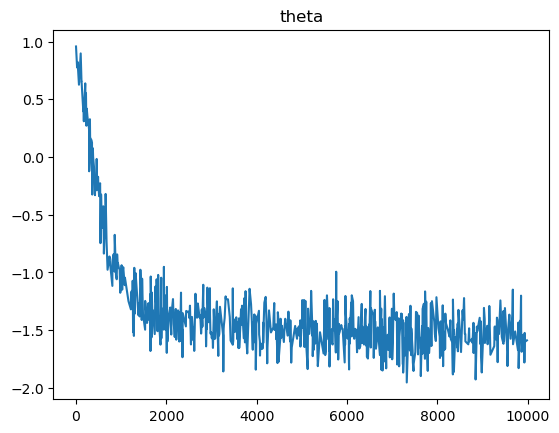

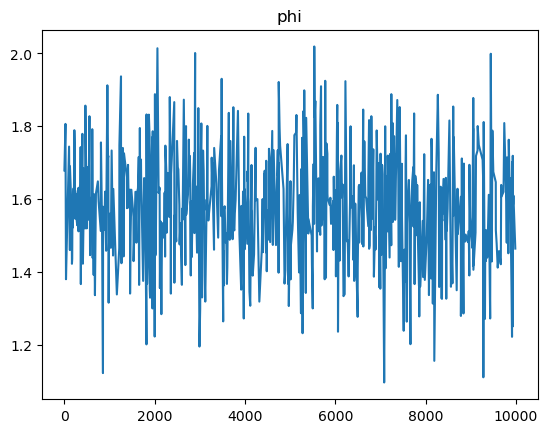

In [ ]:
import json

with open('./train_labels.json') as f: 
    dict_labels = json.load(f)

for i in range(1):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels[f'pdw-{i}']}")
    data = np.load(f"./train/pdw-{i}.npz")
    print(data[features[0]].shape)
    for feature in features:
        if feature == "date": # On trace les différences entre chaque acquisition pour les dates
            plt.title(feature)
            plt.plot(np.diff(data[feature]))
            plt.show()
        else:
            plt.title(feature)
            plt.plot(data["date"], data[feature])
            plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import os
from scipy.stats import moment

On compte sur vous, bonne chance ! 

# On crée les y_train et y_test

In [ ]:
with open('./train_labels.json') as f: 
    dict_train = json.load(f)
    
with open('./test_labels.json') as f: 
    dict_test = json.load(f)

y_train = np.array([1 if dict_train[key] == "menace" else 0 for _, key in enumerate(dict_train)])
y_test = np.array([1 if dict_test[key] == "menace" else 0 for _, key in enumerate(dict_test)])

# On crée les X_train et X_test

In [ ]:
# New relevant feature : width of the largest lobe in the power
def width_power_lobe(pdws):
    """Function to compute the width of the biggest lobe in time"""
    data = np.diff(pdws["puissance"]) # Derivative of power
    thresh = np.mean(data) + np.std(data) # Threshold at mean + 1*sigma
    sup_values = pdws["date"][:-1][data > thresh] # The corresponding times where the derivative of the power is greater than the threshold
    
    return(np.max(np.diff(sup_values))) # Return maximum width

In [ ]:
# Hyperparameters
features = ["date", "largeur", "frequence", "puissance"]
n_features = len(features)
n_sub_features = 4

n_samples_train = len(os.listdir('./train'))
n_samples_test = len(os.listdir('./test'))

In [ ]:
def build_X(mode, n_features, n_sub_features):
    """Mode : train or test"""
    X = np.zeros((0, n_sub_features*n_features + 1))
    
    for i in range(len(os.listdir(f'./{mode}'))):
        file = np.load(f'./{mode}/pdw-{i}.npz')
        row_to_add = np.empty((1, 0))
        
        # We add the biggest lobe as a feature
        row_to_add = np.concatenate([row_to_add, np.array(width_power_lobe(file)).reshape(1, 1)], axis=1)
        
        for i in range(len(features)):
            data = file[features[i]]
            # Pour les dates, on prend la différence des dates de réception d'impulsion
            if features[i] == "date":
                diff_dates = np.diff(data)
                new_features = np.array([np.mean(diff_dates)] + [moment(diff_dates, moment=i) for i in range(2, n_sub_features+1)]).reshape((1, n_sub_features))

            # On garde les autres features telles quelles
            else:
                new_features = np.array([np.mean(data)] + [moment(data, moment=i) for i in range(2, n_sub_features+1)]).reshape((1, n_sub_features))
                
            row_to_add = np.concatenate([row_to_add, new_features], axis=1)
            
        X = np.concatenate([X, row_to_add], axis=0)
        
    return(X)


In [ ]:
X_train = build_X("train", n_features, n_sub_features)
X_test = build_X("test", n_features, n_sub_features)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

(2000, 17)

# On visualise les histogrammes des différentes features pour voir lesquelles sont les plus importantes

In [ ]:
X_train_menace = X_train[y_train == 1]
X_train_non_menace = X_train[y_train == 0]

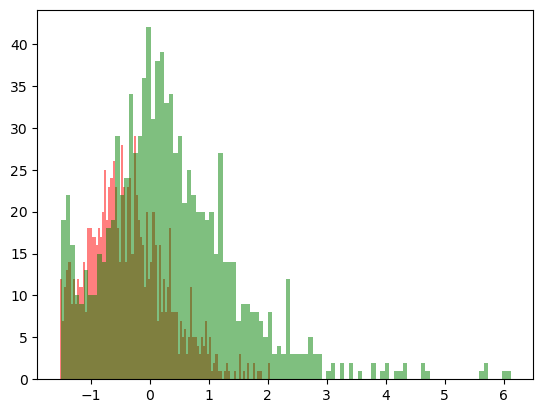

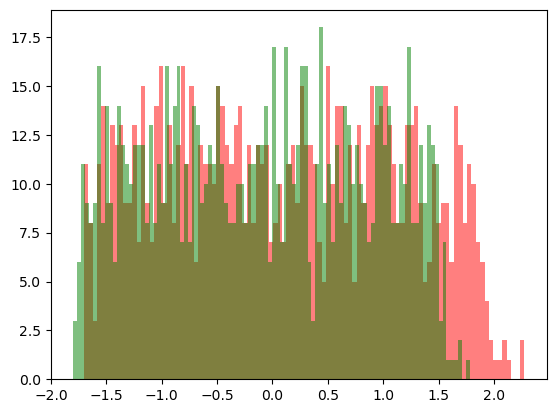

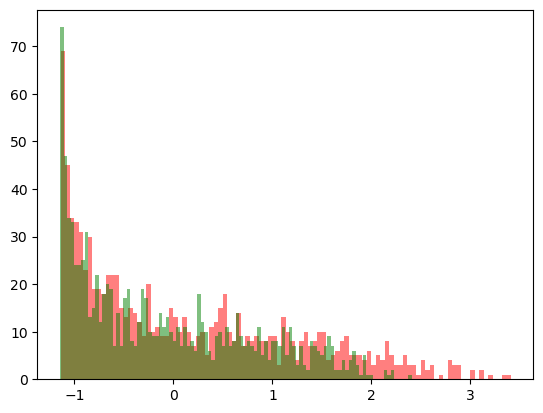

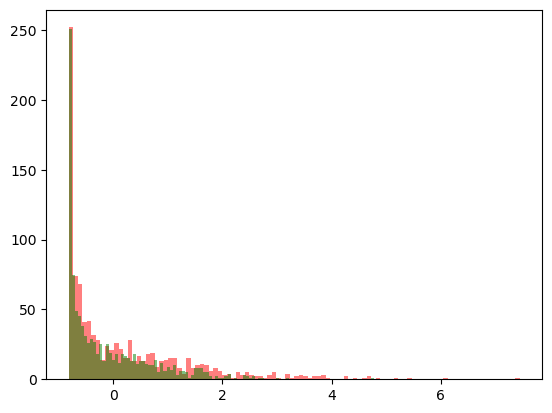

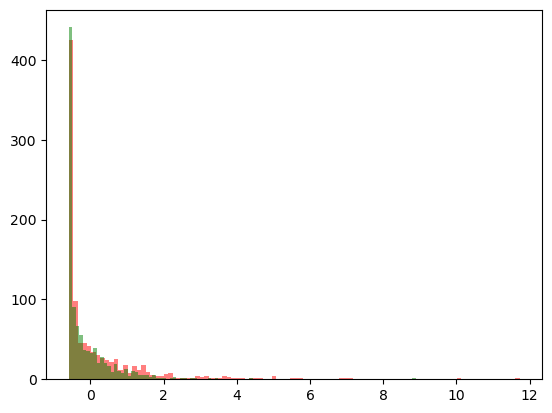

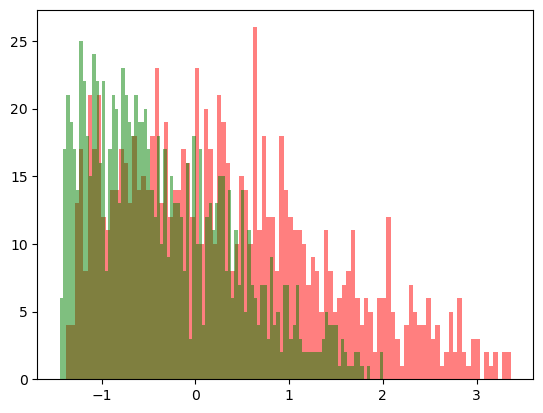

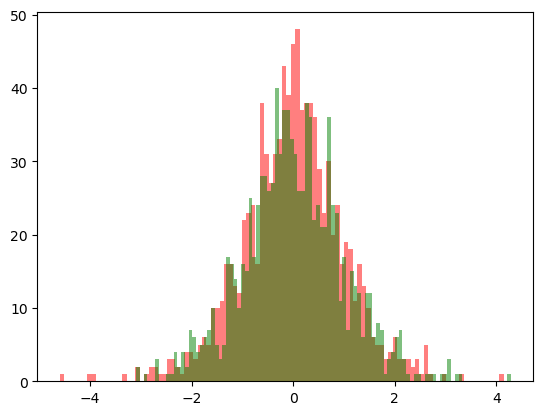

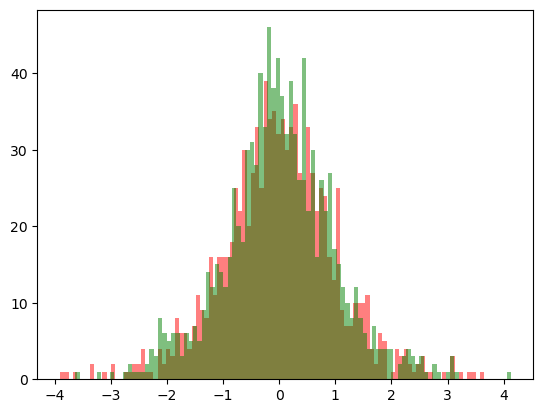

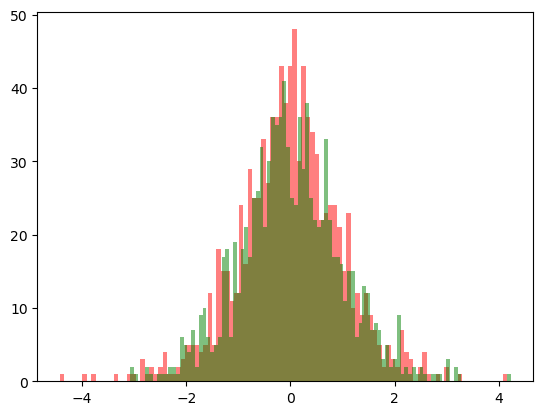

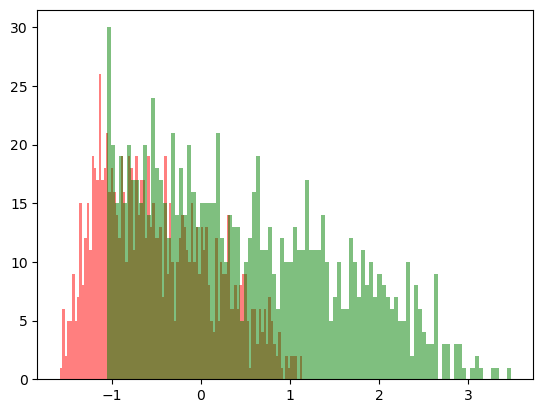

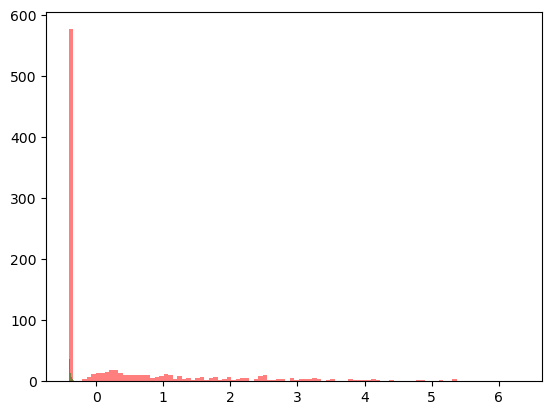

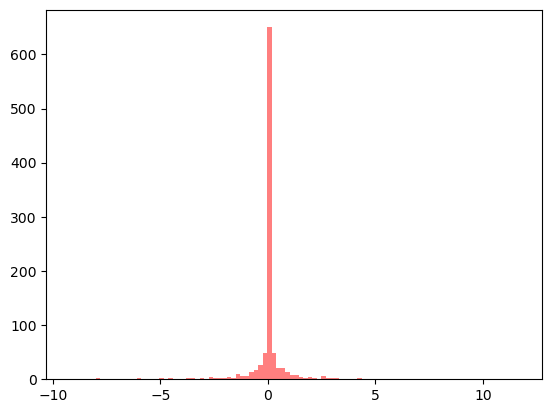

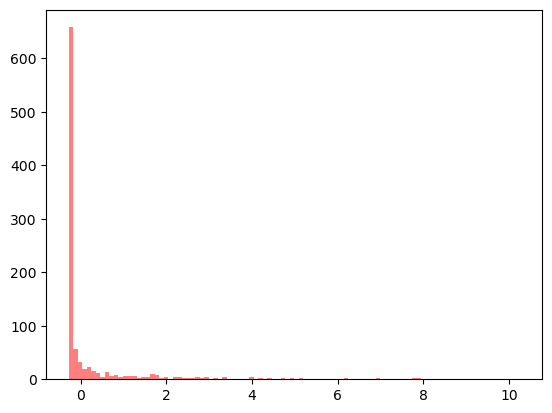

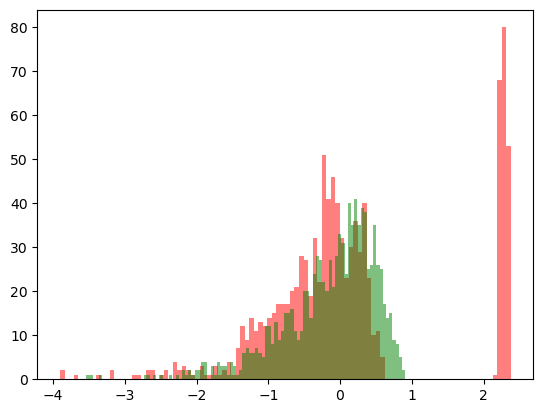

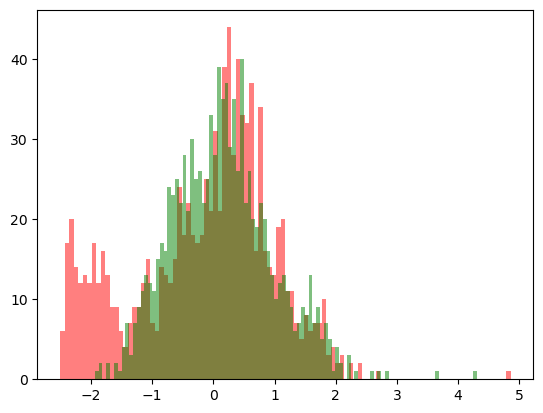

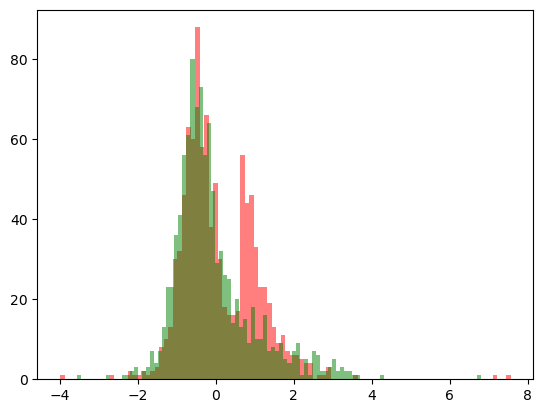

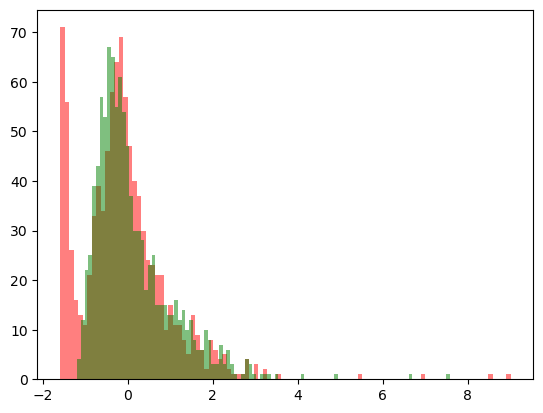

In [ ]:
for col in range(X_train.shape[1]):
    plt.hist(X_train_menace[:, col], bins=100, color='r', alpha=0.5)
    plt.hist(X_train_non_menace[:, col], bins=100, color='g', alpha=0.5)
    plt.show()

# We then scale the values and try different models and choose the best one

In [ ]:
names = [
    "Decision Tree",
    "Random Forest"
]

classifiers = [
    DecisionTreeClassifier(max_depth=8),
    RandomForestClassifier(max_depth=8)
]

Decision Tree


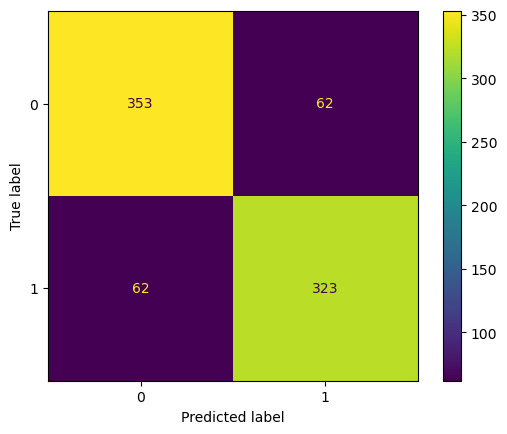

Random Forest


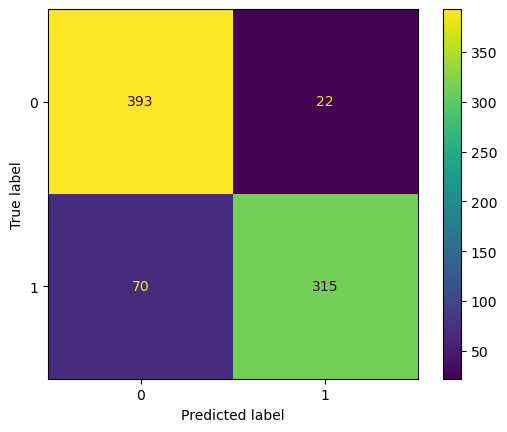

{'Decision Tree': {'Train Accuracy': 0.9115,
  'Test Accuracy': 0.845,
  'Confusion matrix': array([[353,  62],
         [ 62, 323]], dtype=int64)},
 'Random Forest': {'Train Accuracy': 0.9035,
  'Test Accuracy': 0.885,
  'Confusion matrix': array([[393,  22],
         [ 70, 315]], dtype=int64)}}

In [ ]:
final_dict = {}

for name, clf in zip(names, classifiers):
    print(name)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
    disp.plot()
    plt.show()
    
    final_dict[name] = {"Train Accuracy": accuracy_train,
                        "Test Accuracy": accuracy_test,
                        "Confusion matrix": conf_matrix}
    
final_dict

# Not very good with Decision Tree, but quite good with Random Forest (88,5% accuracy)

# Testing with XGBoost

In [ ]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [ ]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [ ]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
# Loading outputs
with open('./train_labels.json') as f: 
    dict_train = json.load(f)
    
with open('./test_labels.json') as f: 
    dict_test = json.load(f)

y_train = np.array([1 if dict_train[key] == "menace" else 0 for _, key in enumerate(dict_train)])
y_test = np.array([1 if dict_test[key] == "menace" else 0 for _, key in enumerate(dict_test)])

# Loading inputs
X_train = build_X("train", n_features, n_sub_features)
X_test = build_X("test", n_features, n_sub_features)

# We scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Creating our classifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_train) # For training
y_pred_test = xgb_model.predict(X_test) # For testing

print(confusion_matrix(y_train, y_pred))
print(confusion_matrix(y_test, y_pred_test))

[[1011    0]
 [   0  989]]
[[357  58]
 [ 56 329]]


100% on training, 85,75% on testing, overfits... Try to do k-fold cross validation and early stopping to lower overfitting

#  Cross Validation

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_index, test_index in kfold.split(X_train):   
    X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
    y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]

    xgb_model = xgb.XGBRegressor(objective="binary:logistic")
    xgb_model.fit(X_train_kf, y_train_kf)
    
    y_pred_kf = xgb_model.predict(X_test_kf)
    
    scores.append(mean_squared_error(y_test_kf, y_pred_kf))
    
display_scores(np.sqrt(scores))

Scores: [0.28988758 0.30593294 0.31800275 0.25760961 0.29448344]
Mean: 0.293
Std: 0.020


In [ ]:
y_pred_test = xgb_model.predict(X_test) # For testing
accuracy_test = accuracy_score(y_test, np.round(y_pred_test))
accuracy_test

0.87125

# Early stopping

In [ ]:
# We stop before the model overfits the training data
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="error")
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])
y_pred = xgb_model.predict(X_test)

accuracy_score(y_test, y_pred)

[0]	validation_0-error:0.14375
[1]	validation_0-error:0.13375
[2]	validation_0-error:0.13375
[3]	validation_0-error:0.13125
[4]	validation_0-error:0.12375
[5]	validation_0-error:0.12625
[6]	validation_0-error:0.12500
[7]	validation_0-error:0.12625
[8]	validation_0-error:0.13375
[9]	validation_0-error:0.13000
[10]	validation_0-error:0.13375
[11]	validation_0-error:0.13375
[12]	validation_0-error:0.12750
[13]	validation_0-error:0.13250


C:\Users\thiba\anaconda3\envs\dlts\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.87625

# We obtain a maximum accuracy of 87,6% on the testing set

# Trying with a MLPClassifier

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(16, 16), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

C:\Users\thiba\anaconda3\envs\dlts\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))

[[961  50]
 [100 889]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1011
           1       0.95      0.90      0.92       989

    accuracy                           0.93      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.93      0.93      0.92      2000



In [ ]:
# Testing
print(confusion_matrix(y_test,predict_test))
print(classification_report(y_test,predict_test))

[[363  52]
 [ 73 312]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       415
           1       0.86      0.81      0.83       385

    accuracy                           0.84       800
   macro avg       0.84      0.84      0.84       800
weighted avg       0.84      0.84      0.84       800

